# Reinforcement Learning Project
## CS182: Artificial Intelligence
## Anusha Murali
## Harvard University

The following was one of my projects for the Artificial Intelligence course (CS182) at Harvard University in the Fall of 2023.
I implemented a number of reinforcement learning algorithms in Python using OpenAI's Frozen Lake Environment as part of my course requirements.


# Reinforcement Learning using OpenAI's Frozen Lake Environment


**Reinforcement Learning** Reinforcement Learning (RL) is a machine learning paradigm where an agent learns to make decisions by interacting with an environment to maximize cumulative rewards. The goal is to learn an optimal policy ($\pi*$) that maximizes long-term rewards.

**Q-Learning** Q-Learning is a model-free, off-policy RL algorithm that learns the Q-function (action-value function) using temporal difference (TD) learning.

**Problem:** 
In this problem, you will be implementing various planning and reinforcement learning algorithms on OpenAI's Frozen Lake Environment. You will need the packages gym==0.21.0, IPython==7.29.0, and matplotlib==3.4.3. In this environment, an agent controls the movement of a character in a 4x4 grid world. Some tiles of the grid are walkable S, for start, F, for frozen, G, for goal), and others lead to the agent falling into the water (H, for hole). The agent is rewarded +1 for reaching the goal state and 0 otherwise. We will work with a few variations of the Frozen Lake environment. In the first version, the parameter is_slippery is set to False, so every action leads to a deterministic tile. When is_slippery is set to True, the movement direction of the agent is uncertain. In particular, if an agent chooses to go in one direction, there is a 1/3 probability the agent goes in the intended direction and a 1/3 probability that the agent goes in each of the directions that are perpendicular to the intended direction. If an agent is on the edge of the map and attempts to move off the map, it simply stays in place.

## Part I Implementation of Value Iteration

**A. Implement value iteration**

*The following code implements value iteration*

In [20]:
from os import system
from time import sleep
import gym 
import numpy as np

State = int
Action = int

class DynamicProgramming:
    """
    Write your algorithms for Policy Iteration and Value Iteration in the appropriate functions below.
    """

    def __init__(self, env, gamma=0.95, epsilon=0.001):
        '''
        Initialize policy, environment, value table (V), policy (policy), and transition matrix (P)
        '''
        self.env = env
        self.num_states = env.observation_space.n
        self.num_actions = env.action_space.n
        self.policy = self.create_initial_policy()
        self.V = np.zeros(self.num_states) # Vector of estimated utilities for each state, states are numbered 0-15, initialized at zero
        self.P = self.env.P # Dict of a Dict of list of tuples. Outer dict keys = states, 0-15, index into a state, you get a dict of 4 actions that can be performed, for each action we have
        # a list of possiable states that you can end up in, then it's a tuple that tells us what prob of ending up in each of those states, the state indexer, the reward of doing that, finally
        # a boolean indicator of if its a terminal state or not
        self.gamma = gamma # Discount rate
        self.epsilon = epsilon # Convergence parameter
        self.rewards = {state:0 for state in range(self.num_states)} # The reward function R(s)
        self.terminal_states = {state:False for state in range(self.num_states)} # Returns a True or False indicating if the game state provided 
        # is in a terminal state (i.e. no further actions can be taken)
        
        for state,actions in env.P.items():
            for action,action_data in actions.items():
                prob, state, r, is_end = action_data[0]
                if is_end==True:
                    self.terminal_states[state] = True # Record if terminal state (ice hole or goal)
                    if r == 1:
                        self.rewards[state] = 1 # If a goal state, then R(s) = 1, else R(s) left at 0
                
    def create_initial_policy(self):
        '''
        A policy is a numpy array of length self.num_states where
        self.policy[state] = action

        You are welcome to modify this function to test out the performance of different policies.
        '''
        # policy is num_states array (deterministic)
        policy = np.zeros(self.num_states, dtype=int)
        return policy

    def updated_action_values(self, state: State) -> np.ndarray:
        """
        This is a useful helper function for implementing value_iteration.
        Given a state (given by index), returns a numpy array of entries
        
        Z_i = SUM[p(s'|s,a_i)*U(s')] over all s' for action a_i
        
        i.e. return a np.array: [Z_1, ..., Z_n]
        
        based on current value function self.V for U(s')
        """
 
        utilityValues = []

        for action in range(self.env.action_space.n):
            utility = 0.0
            for prob, nextState, reward, _ in self.env.P[state][action]:
                utility = utility + prob*(self.gamma * (reward + self.V[nextState]))
            utilityValues.append(utility)
       
        return utilityValues 
    

    def value_iteration(self):
        """
        Perform value iteration to compute the value of every state under the optimal policy.
        This method does not return anything. After calling this method, self.V should contain the
        correct values for each state. Additionally, self.policy should be an array that contains
        the optimal policy, where policies are encoded as indicated in the `create_initial_policy` docstring.
        """
               
        finished = False
        
        # Update utility values until convergence (i.e: the difference between 2 consecutive
        # iteration becomes <= epsilon
        while not finished:
            # Backup the previous Q values for checking convergence
            prevUtility_table = np.copy(self.V) 

            tempTable = []
            # For each state, compute the utility values over all the actions and update 
            # it with the maximum utility value
            for s in range(self.env.observation_space.n):
                # Compute the utility values for all the actions from state s
                utility_values = self.updated_action_values(s)
                # Update temp utility_table[s] with the MAX of uti vals of all actions
                tempTable.append(max(utility_values))

            for s in range(self.env.observation_space.n):
                self.V[s] = tempTable[s]
                
            # If we have reached convergence, break now
            # We want the error for each utility value <= epsilon
            if (np.sum(np.fabs(prevUtility_table - self.V))
                <= self.epsilon/self.env.observation_space.n):
                finished = True

        # Convergence complete. Now update the goal state with
        # a utility value of 1
        self.V[15] = 1.

        # Policy formulation
        for s in range(self.env.observation_space.n):               
            #extract policy by selecting the action which has maximum Q value
            utility_values = self.updated_action_values(s)
            self.policy[s] = np.argmax(np.array(utility_values))
            

    def play_game(self, display=False):
        '''
        Play through one episode of the game under the current policy
        display=True results in displaying the current policy performed on a randomly generated environment in the terminal.
        '''
        self.env.reset()
        episodes = []
        finished = False

        curr_state = self.env.s
        total_reward = 0

        while not finished:
            # display current state
            if display:
                system('cls')
                self.env.render()
                sleep(0.1)

            # find next state
            action = self.policy[curr_state]
            try:
                new_state, reward, finished, info = self.env.step(action)
            except:
                new_state, reward, finished, info, _ = self.env.step(action)
            reward = self.rewards[new_state] # Rewards are realized by entering a new state
            total_reward += reward
            episodes.append([new_state, action, reward])
            curr_state = new_state # Set the current state equal to the new state for the next while loop iteration

        # display end result
        if display:
            system('cls')
            self.env.render()

        print(f"Total Reward from this run: {total_reward}")
        return episodes

    # averages rewards over a number of episodes
    def compute_episode_rewards(self, num_episodes=100, step_limit=1000):
        '''
        Computes the mean, variance, and maximum of episode reward over num_episodes episodes
        '''
        total_rewards = np.zeros(num_episodes);steps_taken = np.zeros(num_episodes)
        for episode in range(num_episodes):
            self.env.reset()
            finished = False
            num_steps = 0
            curr_state = self.env.s
            while not finished and num_steps < step_limit:
                action = self.policy[curr_state]
                try:
                    new_state, reward, finished, info = self.env.step(action)
                except:
                    new_state, reward, finished, info, _ = self.env.step(action)
                reward = self.rewards[new_state]
                total_rewards[episode] += reward
                num_steps += 1
                curr_state = new_state # Set the current state equal to the new state for the next while loop iteration
                

            if reward != 0:
                # If the agent falls into a hole and gets a reward of zero, then record that as zero (already the value of the array)
                # Otherwise, if they do eveutally reach the goal, then record then number of steps taken
                steps_taken[episode] = num_steps

        return np.mean(total_rewards), np.var(total_rewards), np.max(total_rewards), steps_taken


    def print_rewards_info(self, num_episodes=100, step_limit=1000):
        '''
        Prints information from compute_episode_rewards
        '''
        mean, var, best, steps_array = self.compute_episode_rewards(num_episodes=num_episodes, step_limit=step_limit)
        print(f"Mean of Episode Rewards: {mean:.2f}, Variance of Episode Rewards: {var:.2f}, Best Episode Reward: {best}")


**B. Report the mean and variance of the rewards over 1000 episodes of the final policy using the parameters $\gamma = 0.9, \epsilon = 0.001$.**

In [21]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True) # Set up the Frozen lake environmnet 
env.reset()

print("Testing Value Iteration...")
sleep(1)
my_policy = DynamicProgramming(env, gamma=0.9, epsilon=0.001) # Instantiate class object
  
my_policy.value_iteration() # Iterate to derive the final policy
  
my_policy.play_game() # Play through one episode of the game under the current policy
my_policy.print_rewards_info(num_episodes=1000) # Prints information from compute_episode_rewards
sleep(1)

# Compute the episode rewards over 1000 episodes of game playing
mean_val, var_val, max_val, num_steps_array =  my_policy.compute_episode_rewards(num_episodes=1000, step_limit=1000)
print(f"DP: Mean of Episode Rewards: {mean_val:.2f}, Variance of Episode Rewards: {var_val:.2f}, Best Episode Reward: {max_val}")
    

Testing Value Iteration...
Total Reward from this run: 0
Mean of Episode Rewards: 0.09, Variance of Episode Rewards: 0.08, Best Episode Reward: 1.0
DP: Mean of Episode Rewards: 0.09, Variance of Episode Rewards: 0.08, Best Episode Reward: 1.0


**C. For an agent using the policy found by value iteration, plot a histogram (include this in your PDF write-up)
of the number of steps it takes an agent to reach the goal over those 1000 episodes using the final policy. If the agent falls into a hole in the ice and never reaches the goal state, let that be recorded as a zero. Does this agent always reach the goal? Why or why not? Use the map to inform your explanation.**

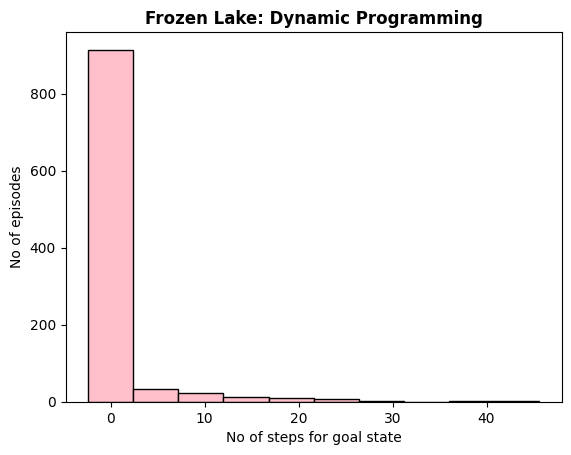

In [22]:
import matplotlib.pyplot as plt
    
plt.hist(num_steps_array, align='left', edgecolor = "black", color = 'pink')

plt.title("Frozen Lake: Dynamic Programming", fontweight = "bold")
plt.ylabel('No of episodes')
plt.xlabel('No of steps for goal state')

plt.show()

No, the agent does not always reach the goal state.  The reason  is that when the frozen lake is created with ${\tt is\_slippery = True}$, an action (LEFT, DOWN, RIGHT, or UP) does not necessarily take the agent to the location specified by the action. It performs the intended action with a probability of 1/3, and it moves the agent in the two directions (RIGHT or LEFT) perpendicular to the intended direction with probabilities of 1/3 each. Therefore, the agent can fall into the hole and will never reach the goal state.  

The histogram supports this claim as it shows nearly 900 episodes (out of a total of 1000) corresponding to 0 (zero) steps, which means that this many episodes resulted in the agent falling into a hole and never reaching the goal state.

## Part II Implement active, model free reinforcement learning in the form of Q-learning

In [23]:
# Model free reinforcement learning
class QLearning:
    """
    Write you algorithm for active model-free Q-learning in the appropriate functions below.
    """

    def __init__(self, env, gamma=0.95, epsilon=0.01):
        """
        Initialize policy, environment, and Q table (Q)
        """
        self.env = env
        self.num_states = env.observation_space.n
        self.num_actions = env.action_space.n 
        self.Q = np.zeros((self.num_states, self.num_actions)) # A 2d-array of states and the values of each action
        self.state_action_counter = np.zeros((self.num_states, self.num_actions))   # keeps track of k_sa
        self.gamma = gamma # Discount rate
        self.epsilon = epsilon # Exploration rate
        self.rewards = {state:0 for state in range(self.num_states)} # The reward function R(s)
        self.terminal_states = {state:False for state in range(self.num_states)} # Returns a True or False indicating if the game state provided 
        # is in a terminal state (i.e. no further actions can be taken)
        
        for state,actions in env.P.items():
            for action,action_data in actions.items():
                prob, state, r, is_end = action_data[0]
                if is_end==True:
                    self.terminal_states[state] = True # Record if terminal state (ice hole or goal)
                    if r == 1:
                        self.rewards[state] = 1 # If a goal state, then R(s) = 1, else R(s) left at 0


    def choose_action(self, state: State) -> Action:
        """
        Returns action based on Q-values using the epsilon-greedy exploration strategy
        """
        return self.env.action_space.sample()      


    def q_learning(self, num_episodes=10000, interval=1000, display=False, step_limit=10000):
        """
        Implement the tabular update for the table of Q-values, stored in self.Q

        Boilerplate code of running several episodes and retrieving the (s, a, r, s') transitions has already been done
        for you.
        """
        mean_returns = []
        for e in range(1, num_episodes+1):
            self.env.reset()
            finished = False

            curr_state = self.env.s
            num_steps = 0

            while not finished and num_steps < step_limit:
                # display current state
                if display:
                    system('cls')
                    self.env.render()
                    sleep(1)

                action = self.choose_action(curr_state)
                try:
                    next_state, reward, finished, info = self.env.step(action)
                except:
                    next_state, reward, finished, info, _ = self.env.step(action)

                reward = self.rewards[next_state]

                
                # Update the state_action_counter
                self.state_action_counter[curr_state][action] +=1
                
                # update Q values. Use the alpha schedule given here. k_SA = how many time we took action A at state S
                alpha = min(0.1, 10 / self.state_action_counter[curr_state][action] ** 0.8)
                
                # Q-learning update rule
                self.Q[curr_state][action] = self.Q[curr_state][action] + \
                                alpha * (reward + self.gamma * np.max(self.Q[next_state]) \
                                         - self.Q[curr_state][action])
     
                num_steps += 1
                curr_state = next_state

            # run tests every interval episodes
            if e % interval == 0:
                print(str(e)+"/"+str(num_episodes),end=" ")
                mean, var, best = self.compute_episode_rewards(num_episodes=100)
                mean_returns.append(mean)

        return mean_returns

    # averages rewards over a number of episodes
    def compute_episode_rewards(self, num_episodes=100, step_limit=1000):
        '''
        Computes the mean, variance, and maximum of episode reward over num_episodes episodes
        '''
        total_rewards = np.zeros(num_episodes)
        for episode in range(num_episodes):
            self.env.reset()
            finished = False
            num_steps = 0
            curr_state = self.env.s
            while not finished and num_steps < step_limit:
                best_actions = np.argwhere(self.Q[curr_state] == np.amax(self.Q[curr_state])).flatten()
                action = np.random.choice(best_actions)
                try:
                    next_state, reward, finished, info = self.env.step(action)
                except:
                    next_state, reward, finished, info, _ = self.env.step(action)
                reward = self.rewards[next_state]
                total_rewards[episode] += reward
                num_steps += 1
                curr_state = next_state

        mean, var, best = np.mean(total_rewards), np.var(total_rewards), np.max(total_rewards)
     #   print(f"Mean of Episode Rewards: {mean:.2f}, Variance of Episode Rewards: {var:.2f}, Best Episode Reward: {best}")
        return mean, var, best

**A. Test your Q-learning algorithm using $\alpha(k_{sa}) = \min(0.1, 10 k_{sa}^{-0.8})$**

In [24]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True)
env.reset()

print("Testing Q-Learning...")
sleep(1)
my_policy = QLearning(env, gamma=0.9, epsilon=0.01) # Instanciate a new class object with the Q learning methods
my_policy.q_learning()
mean_val, var_val, best_val =  my_policy.compute_episode_rewards(num_episodes=1000, step_limit=1000)


Testing Q-Learning...
1000/10000 2000/10000 3000/10000 4000/10000 5000/10000 6000/10000 7000/10000 8000/10000 9000/10000 10000/10000 

**B. Plot the mean returns over 100 episodes of the Q-learning agent that acts solely based on max-Q values after every 1000 episodes (this should be done by using the compute_episode_rewards function). Use the parameters 
$\gamma=0.9, \epsilon=0.01$. How does your Q-learning agent compare to the value-iteration agent following the policy derived from the previous part?**

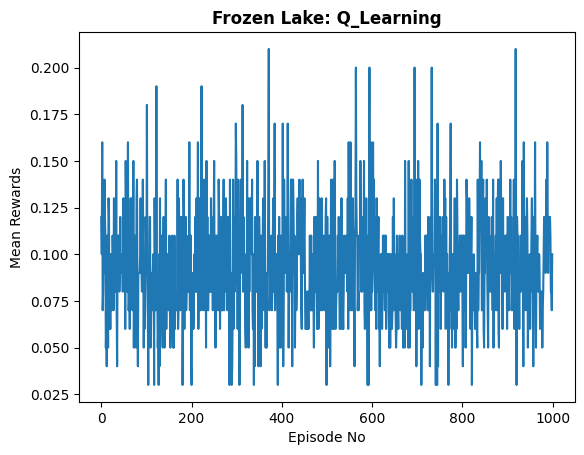

In [26]:
episode_mean_array = []
for i in range(1000):
    mean_val, var_val, best_val =  \
               my_policy.compute_episode_rewards(num_episodes=100, step_limit=1000)
    episode_mean_array.append(mean_val)

plt.plot(episode_mean_array)

plt.title("Frozen Lake: Q_Learning", fontweight = "bold")
plt.ylabel('Mean Rewards')
plt.xlabel('Episode No')

plt.show()

The average reward obtained using the Q-learning algorithm appears to be similar to that from the value iteration. However, the Q-learning algorithm arrived at the convergence faster.